# Active Learning Example

This notebook demonstrates loading data, generating representations (ECFP/MACCS/ChemBERTa),
running a GP-based active learning experiment via the `explainable_al` package, plotting recall,
and saving results. The cells below follow the example script provided in the repository.

In [1]:
# Imports and dataset load
%matplotlib inline
import sys
sys.path.insert(0, '..')

import os
import numpy as np
import pandas as pd
from explainable_al.featuriser import smiles_to_ecfp8_df, get_maccs_from_smiles_list, load_chemberta_embeddings
from explainable_al import experiments
from explainable_al.metrics_plots import make_plot_recall



In [2]:
data_path = os.path.join('..', 'data', 'D2R.csv') if os.path.exists(os.path.join('..', 'data', 'D2R.csv')) else os.path.join('data', 'D2R.csv')
df = pd.read_csv(data_path)
print('Loaded dataset:', data_path)
df.head()

Loaded dataset: ..\data\D2R.csv


,SMILES,Target,affinity,top_2p,top_5p,chemberta_tokens,ECFP8
0,B([C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](...,D2R,5.638546,False,False,"[12, 54, 17, 16, 17, 16, 16, 17, 16, 18, 16, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Br,D2R,2.974694,False,False,"[12, 54, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CCN1CC[C@]23CCCCC2[C@H]1Cc4c3cc(cc4)OC(=O)CC...,D2R,7.525039,False,False,"[12, 16, 38, 16, 16, 23, 20, 16, 16, 16, 21, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C#CCN1CC[C@]23CCCC[C@H]2[C@H]1Cc4c3cc(cc4)O,D2R,10.751122,True,True,"[12, 16, 38, 16, 16, 23, 20, 16, 16, 16, 21, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C#N,D2R,2.036212,False,False,"[12, 16, 38, 23, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3]:
# Generate ECFP (ECFP8)
ecfp = smiles_to_ecfp8_df(df, 'SMILES')
print('ECFP shape:', ecfp.shape)
ecfp[:5]

Processing SMILES:   0%|          | 0/2502 [00:00<?, ?it/s][20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerator
[20:19:49] DEPRECATION WARNING: please use MorganGenerat

ECFP shape: (2502, 4096)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [4]:
# Generate MACCS
maccs = get_maccs_from_smiles_list(df['SMILES'].tolist())
print('MACCS shape:', maccs.shape)
maccs[:5]

MACCS shape: (2502, 167)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
# ChemBERTa embeddings (placeholder - load if precomputed)
npz_path = os.path.join('..', 'data', 'd2r_chemberta_data_new.npz') if os.path.exists(os.path.join('..', 'data', 'd2r_chemberta_data_new.npz')) else 'data/chemberta_embeddings.npz'
if os.path.exists(npz_path):
    emb = load_chemberta_embeddings(npz_path)
    print('Loaded ChemBERTa embeddings:', getattr(emb, 'shape', None))
else:
    print('No precomputed ChemBERTa file found at', npz_path)
    print('To compute embeddings: from explainable_al.featuriser import smiles_to_chemberta; emb = smiles_to_chemberta(df)')

Loaded ChemBERTa embeddings: (2502, 285)


In [6]:
# Run a packaged experiment (uses GP surrogate and pre-defined protocols)
results, dataset_size = experiments.run_experiment(data_path, 'D2R')
print('Protocols returned:', list(results.keys()))

Processing SMILES:   0%|          | 0/2502 [00:00<?, ?it/s][20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerator
[20:19:52] DEPRECATION WARNING: please use MorganGenerat

Epoch 10/150 | Loss: 5.468
Epoch 20/150 | Loss: 5.395
Epoch 30/150 | Loss: 5.352
Epoch 40/150 | Loss: 5.327
Epoch 50/150 | Loss: 5.312
Epoch 60/150 | Loss: 5.303
Epoch 70/150 | Loss: 5.297
Epoch 80/150 | Loss: 5.294
Epoch 90/150 | Loss: 5.292
Epoch 100/150 | Loss: 5.291
Epoch 110/150 | Loss: 5.290
Epoch 120/150 | Loss: 5.290
Epoch 130/150 | Loss: 5.290
Epoch 140/150 | Loss: 5.289
Epoch 150/150 | Loss: 5.289


c:\Users\ss864\Desktop\DD\.conda\lib\site-packages\linear_operator\utils\sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
c:\Users\ss864\Desktop\DD\.conda\lib\site-packages\linear_operator\utils\sparse.py:66: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:80.)
  res = cls(index_tensor, value_tensor, interp_size)
c:\Users\ss864\Desktop\DD\.conda\lib\site-packages\linear_operator\utils\sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is d

Cycle 0 (random): R2=-1.4351 Spearman=0.2838 Acquired=60
active_learning.py cycle complete.

Epoch 10/150 | Loss: 4.376
Epoch 20/150 | Loss: 4.326
Epoch 30/150 | Loss: 4.297
Epoch 40/150 | Loss: 4.280
Epoch 50/150 | Loss: 4.269
Epoch 60/150 | Loss: 4.263
Epoch 70/150 | Loss: 4.259
Epoch 80/150 | Loss: 4.257
Epoch 90/150 | Loss: 4.256
Epoch 100/150 | Loss: 4.255
Epoch 110/150 | Loss: 4.255
Epoch 120/150 | Loss: 4.254
Epoch 130/150 | Loss: 4.254
Epoch 140/150 | Loss: 4.254
Epoch 150/150 | Loss: 4.254
Cycle 1 (random): R2=-0.7754 Spearman=0.2973 Acquired=90
active_learning.py cycle complete.

Epoch 10/150 | Loss: 3.968
Epoch 20/150 | Loss: 3.927
Epoch 30/150 | Loss: 3.904
Epoch 40/150 | Loss: 3.889
Epoch 50/150 | Loss: 3.881
Epoch 60/150 | Loss: 3.876
Epoch 70/150 | Loss: 3.873
Epoch 80/150 | Loss: 3.871
Epoch 90/150 | Loss: 3.870
Epoch 100/150 | Loss: 3.869
Epoch 110/150 | Loss: 3.869
Epoch 120/150 | Loss: 3.869
Epoch 130/150 | Loss: 3.869
Epoch 140/150 | Loss: 3.869
Epoch 150/150 | Loss

Prepared 11 rows for plotting


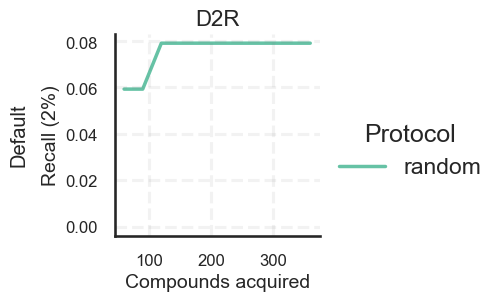

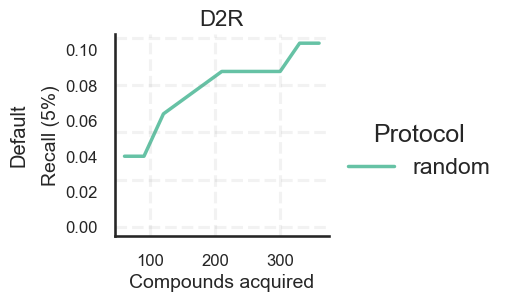

In [7]:
# Prepare results for plotting and visualize recall (2% and 5%)
rows = []
for protocol_name, cycles in results.items():
    for c in cycles:
        rows.append({
            'Protocol': protocol_name,
            'Compounds acquired': c.get('compounds_acquired', 0),
            'Recall (2%)': c.get('top_2p', 0) / max(1, 0.02 * dataset_size),
            'Recall (5%)': c.get('top_5p', 0) / max(1, 0.05 * dataset_size),
        })
plot_df = pd.DataFrame(rows)
print('Prepared', len(plot_df), 'rows for plotting')
plot_df['Dataset'] = 'D2R'

make_plot_recall(plot_df, y='Recall (2%)')
make_plot_recall(plot_df, y='Recall (5%)')


In [8]:
print(plot_df.columns.tolist())
print(plot_df.head())


['Protocol', 'Compounds acquired', 'Recall (2%)', 'Recall (5%)', 'Dataset', 'Model']
  Protocol  Compounds acquired  Recall (2%)  Recall (5%) Dataset    Model
0   random                  60     0.059952     0.039968     D2R  Default
1   random                  90     0.059952     0.039968     D2R  Default
2   random                 120     0.079936     0.063949     D2R  Default
3   random                 150     0.079936     0.071942     D2R  Default
4   random                 180     0.079936     0.079936     D2R  Default


In [9]:
# Save cycle-level CSV outputs
out_dir = 'results'
os.makedirs(out_dir, exist_ok=True)
for protocol_name, cycles in results.items():
    pd.DataFrame(cycles).to_csv(os.path.join(out_dir, f'results_{protocol_name}.csv'), index=False)
print('Saved results to', out_dir)

Saved results to results
